# [E16] SRGAN 활용하기

### 목차
* 프로젝트 1: 직접 고른 이미지로 SRGAN 실험하기
    * 프로젝트 1-1.
    * 프로젝트 1-2.
* 프로젝트 2: SRGAN을 이용해 고해상도 gif 생성하기
    1. gif 파일 불러오기
    2. 프레임별 Super Resolution 진행하기
    3. 프레임을 합쳐 gif 만들기
    4. Jupyter notebook에 gif 표시하기
* 회고
---
### 루브릭 평가 기준
1. SRGAN을 이용해 고해상도의 이미지를 생성하였다.
    * SRGAN을 통해 생성된 이미지를 제출하였다.
2. 다양한 해상도의 이미지에 대해 시각화를 통해 원본, SRGAN생성본, interpolation생성본을 비교분석하였다.
    * 이미지의 특성과 super resolution 방법을 관련지어 생성 결과를 체계적으로 분석하였다.
3. 저해상도 gif 동영상을 고해상도 동영상으로 성공적으로 변환하였다.
    * 저해상도 원본 gif와 생성된 고해상도 gif의 해상도 차이가 시각적으로 확인 가능하다.

# 프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기
## 프로젝트 1-1.
1. (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
2. 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다. cv2.resize()를 사용해 봅시다.
3. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.
4. 2의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 마찬가지로 cv2.resize()를 사용해 봅시다.
5. 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.
6. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

(1080, 1920, 3)


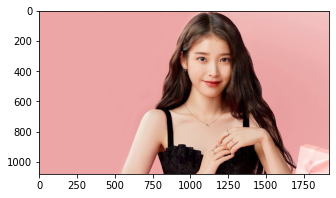

In [2]:
# 고해상도 이미지 불러오기
hr_image = cv2.imread(os.getenv('HOME') + '/aiffel/super_resolution/iu_image_1.jpg')
hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)

print(hr_image.shape)

plt.figure(figsize=(6,3))
plt.imshow(hr_image)

(270, 480, 3)


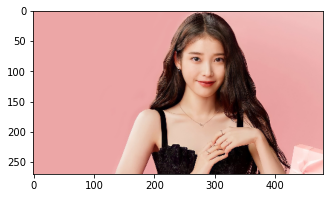

In [3]:
# 이미지 사이즈 줄이기
lr_image = cv2.resize(
    hr_image,
    dsize=(hr_image.shape[1]//4, hr_image.shape[0]//4)
)

print(lr_image.shape)

plt.figure(figsize=(6,3))
plt.imshow(lr_image)

In [4]:
# pre-trained 모델 로드
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [5]:
# SRGAN으로 고해상도 이미지 생성
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)

for i, (lr, hr) in enumerate(valid):
    if i == 6: break

srgan_hr = apply_srgan(lr_image)

In [6]:
# bicubic interpolation으로 이미지 사이즈 키우기
bicubic_hr = cv2.resize(
    lr_image, 
    dsize=(hr_image.shape[1], hr_image.shape[0]), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

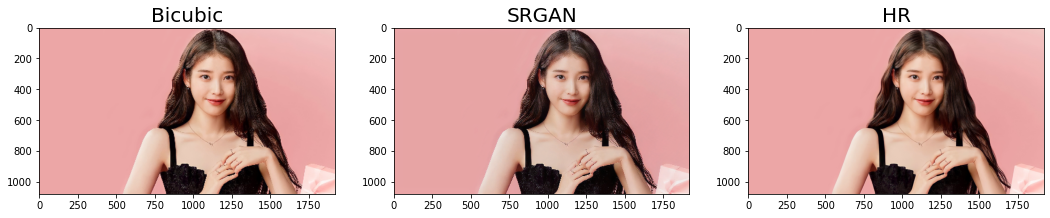

In [7]:
# 시각화
images = [bicubic_hr, srgan_hr, hr_image]
titles = ["Bicubic", "SRGAN", "HR"]

plt.figure(figsize=(18,5))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

In [8]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

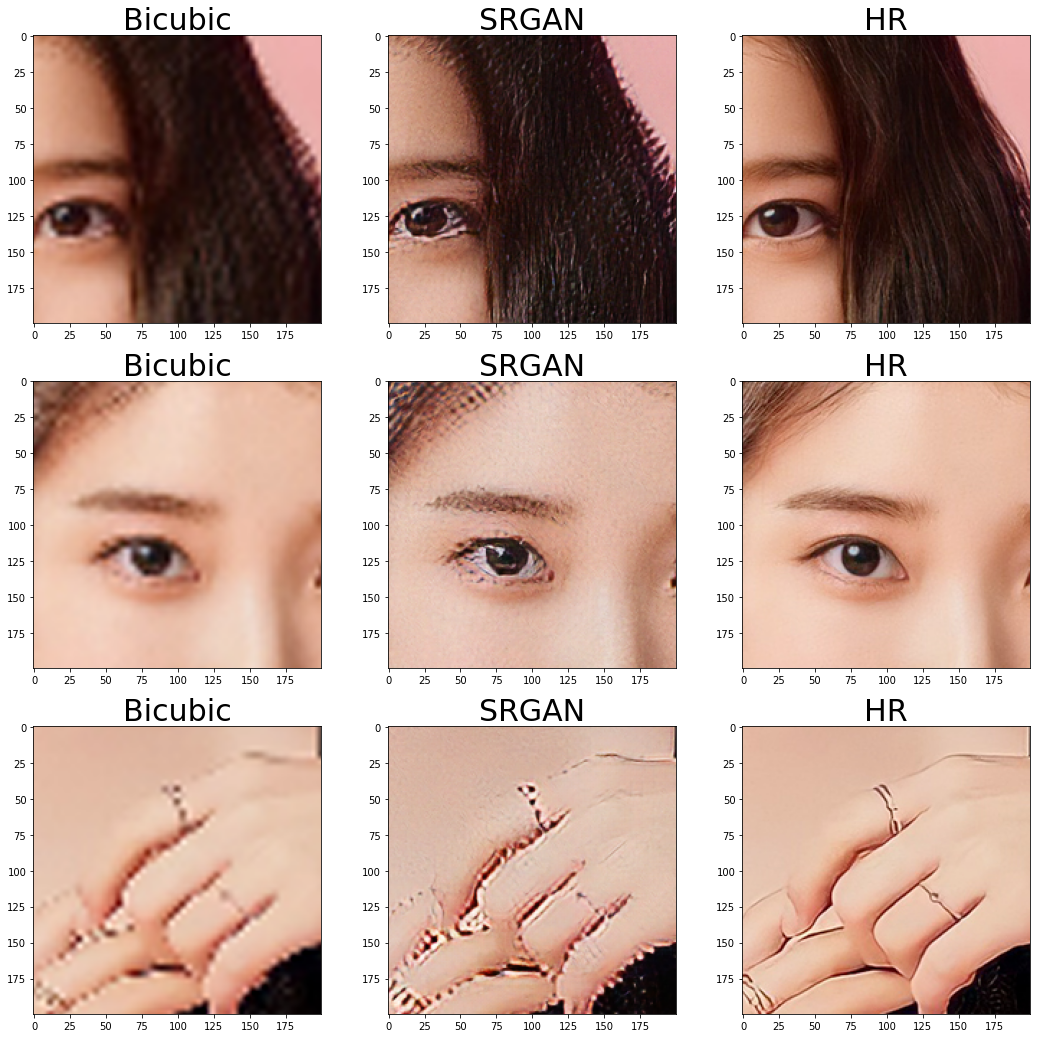

In [9]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(200,1200), (200,1000), (750,1150)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    img3 = crop(hr_image, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

* 고해상도 이미지를 이용하여, 저해상도 이미지로 변환한 후 다시 고해상도로 복원했을 때의 모습이다.
* 이미지의 전체적인 모습을 확인했을때는 해상도의 차이를 눈으로 확인하기는 어려웠다.
* 그러나, 이미지를 확인해보면 각각의 해상도 차이를 확인할 수 있었다.
    * Bicubic의 경우, 전체적인 이미지가 뿌옇다.
    * SRGAN의 경우, Bicubic에 비해 경계선이 확실하게 나타나지만, 사진이라기 보다는 그림과 같은 느낌의 거친 질감이 느껴진다.
* 확실한 것은, 모델을 이용하여 만든 고해상도 이미지(Bicubic, SRGAN)보다 원본 이미지(HR)의 해상도가 훨씬 더 좋다고 말할 수 있고, 결과적으로 모델의 한계가 있다는 것을 확인할 수 있다.

## 프로젝트 1-2.

1. (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
2. 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.
3. 1에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. cv2.resize()를 사용해 봅시다.
4. 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.
5. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

(279, 296, 3)


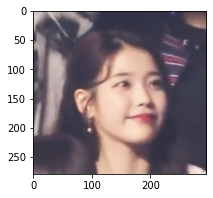

In [10]:
# 저해상도 이미지 불러오기
image = cv2.imread(os.getenv('HOME') + '/aiffel/super_resolution/iu_image_6.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(image.shape)

plt.figure(figsize=(6,3))
plt.imshow(image)

In [11]:
# SRGAN으로 고해상도 이미지 생성
srgan_hr = apply_srgan(image)

In [12]:
# bicubic interpolation으로 이미지 사이즈 키우기
bicubic_hr = cv2.resize(
    image, 
    dsize=(image.shape[1]*4, image.shape[0]*4), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

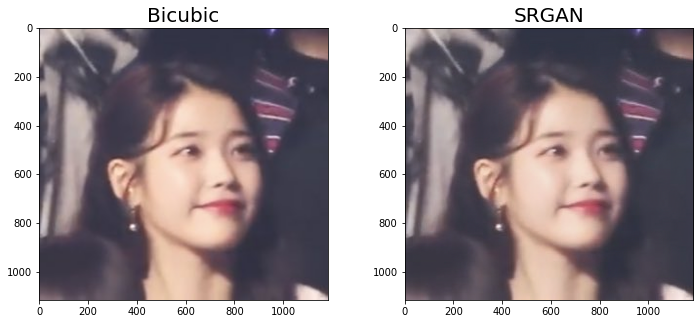

In [13]:
# 시각화
images = [bicubic_hr, srgan_hr]
titles = ["Bicubic", "SRGAN"]

plt.figure(figsize=(12,5))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

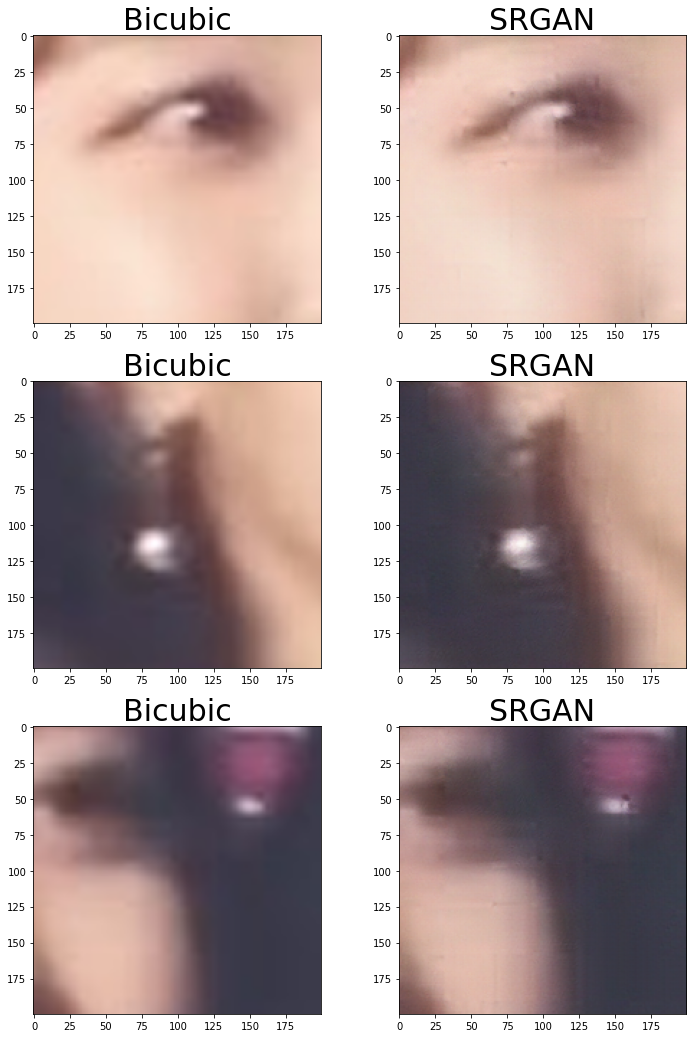

In [14]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(450,500), (700,300), (450,800)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    images.extend([img1, img2])

labels = ["Bicubic", "SRGAN"] * 3

plt.figure(figsize=(12,18))
for i in range(6):
    plt.subplot(3,2,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

* 저해상도 이미지를 고해상도로 복원했을 때의 모습이다.
* 이미지의 전체적인 모습을 확인했을때는 해상도의 차이를 눈으로 확인하기는 어려웠다.
* 그러나, 이미지를 확인해보면 각각의 해상도 차이를 확인할 수 있었다.
    * 두 이미지 모두, 화질이 좋아졌다고 말할 수 있을지가 의문이다.
    * Bicubic의 경우, 전체적으로 부드러워진 느낌을 받을 수 있다.
    * SRGAN의 경우, 오히려 더 흐릿해진 것이 아닌가 싶을 정도로, 저화질의 이미지로 확인되어진다.
* 저해상도 이미지를 고해상도로 바꾸는 과정에서, 이미지 데이터 내에 아무런 정보를 담고있지 않는 데이터들이 추가되면서, 이미지에 노이즈가 생겼기에 이런 현상이 나타나는 것이 아닌가 생각된다.

# 프로젝트 2: SRGAN을 이용해 고해상도 gif 생성하기
## 1. gif 파일 불러오기

In [15]:
import cv2
import os

gif_path = os.getenv('HOME') + '/aiffel/super_resolution'
gif = cv2.VideoCapture(os.path.join(gif_path, 'book_lr.gif'))

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 22
frame 크기 : (215, 380, 3)


## 2. 프레임별 Super Resolution 진행하기

In [16]:
frames_sr_bicubic = []
for frame in frames:
    frames_sr_bicubic.append(cv2.resize(
        frame, 
        dsize=(frame.shape[1]*4, frame.shape[0]*4), 
        interpolation=cv2.INTER_CUBIC
    ))

In [17]:
frames_sr_srgan = []
for frame in frames:
    frames_sr_srgan.append(apply_srgan(frame))

## 3. 프레임을 합쳐 gif 만들기

In [18]:
import imageio

imageio.mimsave(os.path.join(gif_path, 'book_lr_bicubic.gif'), frames_sr_bicubic)
imageio.mimsave(os.path.join(gif_path, 'book_lr_srgan.gif'), frames_sr_srgan)

## 4. Jupyter notebook에 gif 표시하기

In [19]:
from IPython.display import Image as show_gif

# show_gif(os.path.join(gif_path, 'book_lr.gif'), width=800) # width 는 적당히 큰 값으로 설정해주세요

In [20]:
# show_gif(os.path.join(gif_path, 'book_lr_bicubic.gif'), width=800) # 위에서 설정한 width와 같은 값으로 설정해주세요

In [21]:
# show_gif(os.path.join(gif_path, 'book_lr_srgan.gif'), width=800) # 위에서 설정한 width와 같은 값으로 설정해주세요

## 5. 다른 파일에도 적용해보기

In [22]:
def gif_super_resolution(filename):
    gif = cv2.VideoCapture(os.path.join(gif_path, filename))

    isTrue = True
    frames = []
    while isTrue:
        isTrue, frame = gif.read()
        if isTrue:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
    
    print("frame 수 :", len(frames))
    print("frame 크기 :", (frames[0].shape))

    frames_sr_bicubic = []
    for frame in frames:
        frames_sr_bicubic.append(cv2.resize(
            frame, 
            dsize=(frame.shape[1]*4, frame.shape[0]*4), 
            interpolation=cv2.INTER_CUBIC
        ))
        
    frames_sr_srgan = []
    for frame in frames:
        frames_sr_srgan.append(apply_srgan(frame))
    
    return frames_sr_bicubic, frames_sr_srgan

In [23]:
frames_sr_bicubic, frames_sr_srgan = gif_super_resolution('wine_lr.gif')
imageio.mimsave(os.path.join(gif_path, 'wine_lr_bicubic.gif'), frames_sr_bicubic)
imageio.mimsave(os.path.join(gif_path, 'wine_lr_srgan.gif'), frames_sr_srgan)

frame 수 : 13
frame 크기 : (340, 355, 3)


In [24]:
frames_sr_bicubic, frames_sr_srgan = gif_super_resolution('fire_lr.gif')
imageio.mimsave(os.path.join(gif_path, 'fire_lr_bicubic.gif'), frames_sr_bicubic)
imageio.mimsave(os.path.join(gif_path, 'fire_lr_srgan.gif'), frames_sr_srgan)

frame 수 : 14
frame 크기 : (282, 300, 3)


* gif 이미지를 확인했을 때, Bicubic과 SRGAN으로 만든 이미지들이 더 좋은 화질을 갖는 것을 확인할 수 있다.
* Bicubic의 이미지는 전체적으로 부드러운 느낌이 들지만, 기존 이미지에 비해서 조금 뭉개지는 느낌이 든다.
* SRGAN의 이미지는 뚜렷하지만 거친 질감이 느껴지며, 화질이 좋아진 듯한 느낌이 들지만, 우리 눈에는 기존의 이미지가 더 보기 좋다는 생각도 든다.

# 회고

* 모델을 이용해서 저화질의 이미지를 고화질로 바꾸는 작업을 수행할 수 있다는 것이 신기했다. 그러나, 저해상도 이미지를 고해상도로 복원하는 과정에서 해당 모델에 대한 의문이 생겼다. 진짜 해상도를 높이는 기능을 수행하는 것일까? 단순히 이미지를 조금 더 부드럽게 만들거나, 경계를 뚜렷하게 만드는 과정을 통해서 이미지의 해상도를 높인 것 같은 착각을 하는 것은 아닐까? 아니면, 우리가 사용한 모델이 super resolution의 기능을 수행하는 좋은 모델이 아닌 것 일까? 분명 좋은 기술이고, 대단한 기술인 것은 사실이지만, 해당 노드에서는 super resolution의 대단함을 느끼기에는 부족함이 있었다고 생각한다. 만약 내가 고른 이미지가 문제라면, super resolution은 특정 이미지에 대해서만 좋은 기능을 수행하는 계륵과 같은 기술이라고 생각한다.
* 전체적으로 이미지를 변환시키는 과정에서, Bicubic은 원본 이미지를 조금 뭉개는 느낌을 받았다. 이렇게 이미지를 뭉갬으로서, 이미지를 보다 부드럽게 만드는 역할을 수행하는 것 같다. 반면 SRGAN은 이미지를 거친 느낌으로 변환하는 것 같다. 전체적으로 원본 이미지보다 거친 느낌이 들고, 경계선들이 뚜렷해지는 느낌이다. 개인적으로 SRGAN보다 Bicubic 이미지가 화질이 더 좋다(혹은 보기 좋다)고 생각한다.